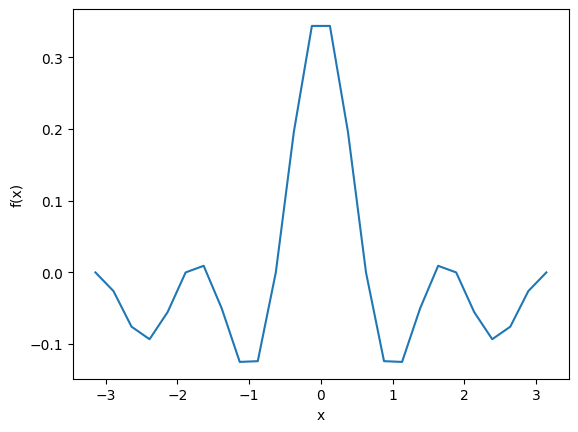

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

domain = jnp.array([-jnp.pi, jnp.pi])
omegas = jnp.array([1, 2, 3, 4])
coefficients = jnp.array([0.5, 0.5, 0.5, 0.5])

# Calculate the number of required samples to satisfy the Nyquist criterium
n_d = int(jnp.ceil(2 * jnp.max(jnp.abs(domain)) * jnp.max(omegas)))
# Sample the domain linearly
x = jnp.linspace(domain[0], domain[1], num=n_d)


# define our Fourier series f(x)
def f(x):
    return 1 / jnp.linalg.norm(omegas) * jnp.sum(coefficients * jnp.cos(omegas.T * x))


# evaluate f(x) on the domain samples
y = jnp.stack([f(sample) for sample in x])

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.savefig("figures/fourier_series_light.png", dpi=100, transparent=True)
plt.show()

In [2]:
from qml_essentials.model import Model

model = Model(
    n_qubits=4,
    n_layers=1,
    circuit_type="Circuit_19",
)

Epoch: 10, Cost: 0.0098
Epoch: 20, Cost: 0.0074
Epoch: 30, Cost: 0.0066
Epoch: 40, Cost: 0.0057
Epoch: 50, Cost: 0.0052
Epoch: 60, Cost: 0.0048
Epoch: 70, Cost: 0.0046
Epoch: 80, Cost: 0.0044
Epoch: 90, Cost: 0.0043
Epoch: 100, Cost: 0.0042


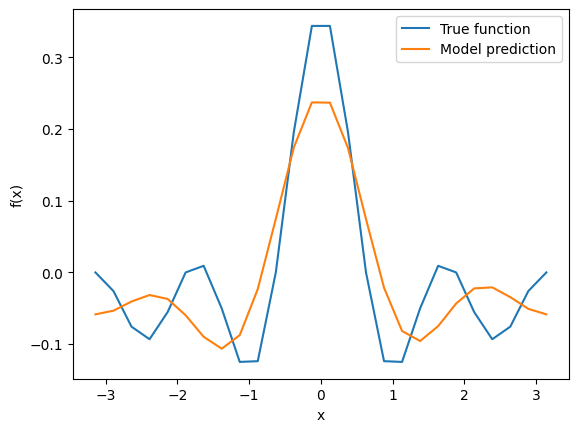

In [3]:
import pennylane as qml
import optax
from jax import grad

def cost_fct(params):
    y_hat = model(params=params, inputs=x, force_mean=True)
    return jnp.mean((y_hat - y) ** 2)

params = model.params
opt = optax.adam(0.01)
opt_state = opt.init(params)

for epoch in range(1, 101):
    grads = grad(cost_fct)(params)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    cost_val = cost_fct(params)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Cost: {cost_val:.4f}")

plt.plot(x, y, label="True function")
plt.plot(
    x, model(params=model.params, inputs=x, force_mean=True), label="Model prediction"
)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.savefig("figures/trained_series_light.png", dpi=100, transparent=True)
plt.show()

## Trainable Frequencies

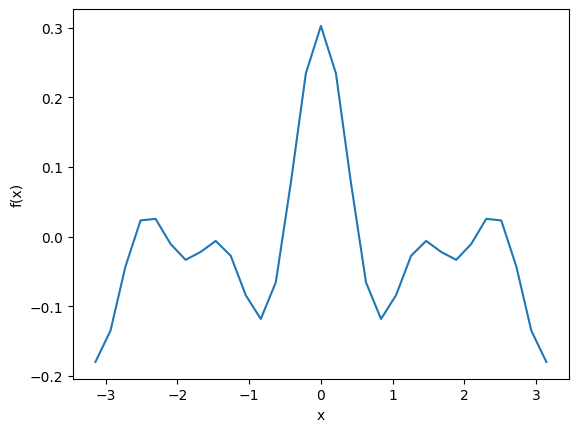

In [4]:
domain = jnp.array([-jnp.pi, jnp.pi])
omegas = jnp.array([1.2, 2.6, 3.4, 4.9])
coefficients = jnp.array([0.5, 0.5, 0.5, 0.5])

# Calculate the number of required samples to satisfy the Nyquist criterium
n_d = int(jnp.ceil(2 * jnp.max(jnp.abs(domain)) * jnp.max(omegas)))
# Sample the domain linearly
x = jnp.linspace(domain[0], domain[1], num=n_d)


# define our Fourier series f(x)
def f(x):
    return 1 / jnp.linalg.norm(omegas) * jnp.sum(coefficients * jnp.cos(omegas.T * x))


# evaluate f(x) on the domain samples
y = jnp.stack([f(sample) for sample in x])

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.savefig(
    "figures/fourier_series_tf_light.png", dpi=100, transparent=True, edgecolor="white"
)
plt.show()

In [5]:
model = Model(
    n_qubits=4, n_layers=1, circuit_type="Circuit_19", trainable_frequencies=False
)
model_tf = Model(
    n_qubits=4, n_layers=1, circuit_type="Circuit_19", trainable_frequencies=True
)

Training fixed frequency model
Epoch: 10, Cost: 0.0066
Epoch: 20, Cost: 0.0051
Epoch: 30, Cost: 0.0045
Epoch: 40, Cost: 0.0040
Epoch: 50, Cost: 0.0037
Epoch: 60, Cost: 0.0035
Epoch: 70, Cost: 0.0033
Epoch: 80, Cost: 0.0032
Epoch: 90, Cost: 0.0031
Epoch: 100, Cost: 0.0030

Training trainable frequency model
Epoch: 10, Cost: 0.006524
Epoch: 20, Cost: 0.005055
Epoch: 30, Cost: 0.004358
Epoch: 40, Cost: 0.003750
Epoch: 50, Cost: 0.003328
Epoch: 60, Cost: 0.003024
Epoch: 70, Cost: 0.002857
Epoch: 80, Cost: 0.002799
Epoch: 90, Cost: 0.002779
Epoch: 100, Cost: 0.002759


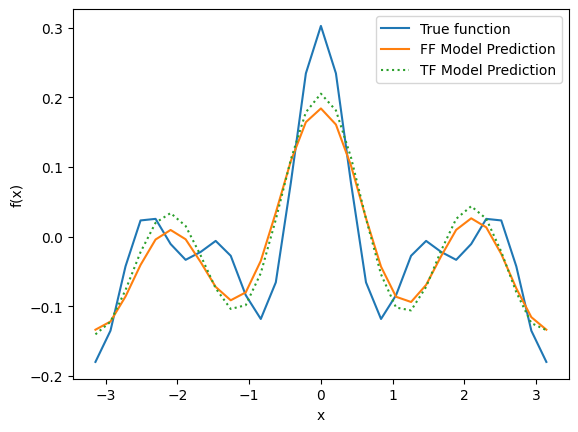

In [6]:
# - Fixed Frequencies -
params = model.params
opt = optax.adam(0.01)
opt_state = opt.init(params)

print("Training fixed frequency model")
for epoch in range(1, 101):
    grads = grad(cost_fct)(params)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    cost_val = cost_fct(params)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Cost: {cost_val:.4f}")

# - Trainable Frequencies -
all_params = (model_tf.params, model_tf.enc_params)
opt = optax.adam(0.01)
opt_state = opt.init(all_params)

def cost_fct_tf(all_params):
    y_hat = model_tf(params=all_params[0], enc_params=all_params[1], inputs=x, force_mean=True)
    return jnp.mean((y_hat - y) ** 2)


print(f"\nTraining trainable frequency model")
for epoch in range(1, 101):
    grads = grad(cost_fct_tf)(all_params)
    updates, opt_state = opt.update(grads, opt_state, all_params)
    all_params = optax.apply_updates(all_params, updates)
    cost_val_tf = cost_fct_tf(all_params)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Cost: {cost_val_tf:.6f}")

plt.plot(x, y, label="True function")
plt.plot(
    x,
    model(params=model.params, inputs=x, force_mean=True),
    label="FF Model Prediction",
)
plt.plot(
    x,
    model_tf(
        params=model_tf.params,
        enc_params=model_tf.enc_params,
        inputs=x,
        force_mean=True,
    ),
    label="TF Model Prediction",
    linestyle="dotted",
)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.savefig(
    "figures/trained_series_tf_light.png", dpi=100, transparent=True, edgecolor="white"
)
plt.show()

In [7]:
print(f"Encoding parameters of the fixed frequencies model: {model.enc_params}")
print(
    f"Encoding parameters of the trainable frequencies model: {jnp.round(model_tf.enc_params, 3)}"
)

Encoding parameters of the fixed frequencies model: [[1.]
 [1.]
 [1.]
 [1.]]
Encoding parameters of the trainable frequencies model: [[1.35 ]
 [1.362]
 [0.788]
 [0.931]]


Epoch: 10, Cost: 0.0555
Epoch: 20, Cost: 0.0455
Epoch: 30, Cost: 0.0372
Epoch: 40, Cost: 0.0315
Epoch: 50, Cost: 0.0273
Epoch: 60, Cost: 0.0240
Epoch: 70, Cost: 0.0216
Epoch: 80, Cost: 0.0199
Epoch: 90, Cost: 0.0189
Epoch: 100, Cost: 0.0183


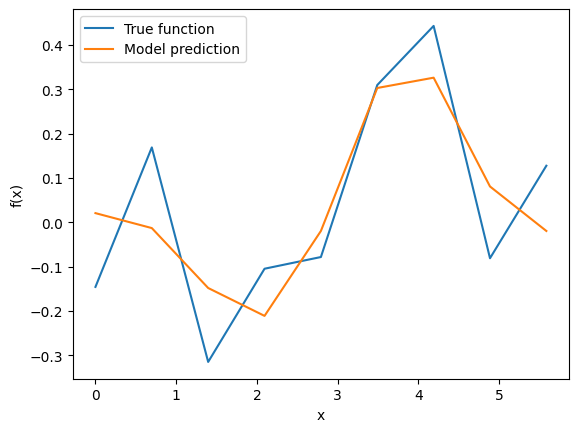

In [9]:
import pennylane as qml
from qml_essentials.model import Model
from qml_essentials.coefficients import Datasets
import matplotlib.pyplot as plt
from jax import random

# start with a model
model = Model(
    n_qubits=4,
    n_layers=1,
    circuit_type="Circuit_19",
)

# initialize the optimizer
params = model.params
opt = optax.adam(0.01)
opt_state = opt.init(params)

# generate a Fourier series dataset
domain_samples, fourier_samples, coefficients = (
                    Datasets.generate_fourier_series(
                        random.key(1000),
                        model=model,
                    )
                )

# cost function uses the domain samples as input and compares with the
# Fourier series samples obtained from the dataset
def cost_fct(params):
    y_hat = model(params=params, inputs=domain_samples, force_mean=True)

    return jnp.mean((y_hat - fourier_samples) ** 2)

for epoch in range(1, 101):
    grads = grad(cost_fct)(params)
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    cost_val = cost_fct(params)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Cost: {cost_val:.4f}")

plt.plot(domain_samples, fourier_samples, label="True function")
plt.plot(
    domain_samples, model(params=model.params, inputs=domain_samples, force_mean=True), label="Model prediction"
)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.savefig("figures/trained_series_dataset_light.png", dpi=100, transparent=True)
plt.show()